In [5]:
import plot_utils as u
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from tqdm.notebook import tqdm

In [6]:
results_dir = Path('long_pi_grid')
tail_lengths = [1000, 2000, 5000, 10000, 20000, 30000]
line_colors = ['#dddddd', '#999999', '#646464', '#484848', '#2c2c2c', '#000000']
setpoint = 1.0414E-4
lam = 3e-9

In [7]:
results = dict()
for tl in tail_lengths:
    results[tl] = []
for d in tqdm(list(results_dir.iterdir())):
    if not d.is_dir():
        continue
    for output_file in d.glob('*.out'):
        config = u.read_config_from_output_file(output_file)
    controller_t, controller_p, controller_b = u.load_controller_data(d)
    lfp_time, lfp_voltage = u.load_stn_lfp(d)
    
    dt = controller_t[1] = controller_t[0]
    
    for tl in tail_lengths:
        
        num_samples = int(tl / dt)
        j = np.sum((controller_b[-num_samples:] - setpoint) ** 2 + lam * controller_p[-num_samples:] ** 2) / (2 * num_samples)
        
        mse = u.compute_mse(lfp_time, lfp_voltage, tail_length=tl)
        teed = u.compute_teed(controller_t, controller_p, 80, 130, 1)
        results[tl].append((config['ti'], config['kp'], mse, teed, j))

  0%|          | 0/300 [00:00<?, ?it/s]

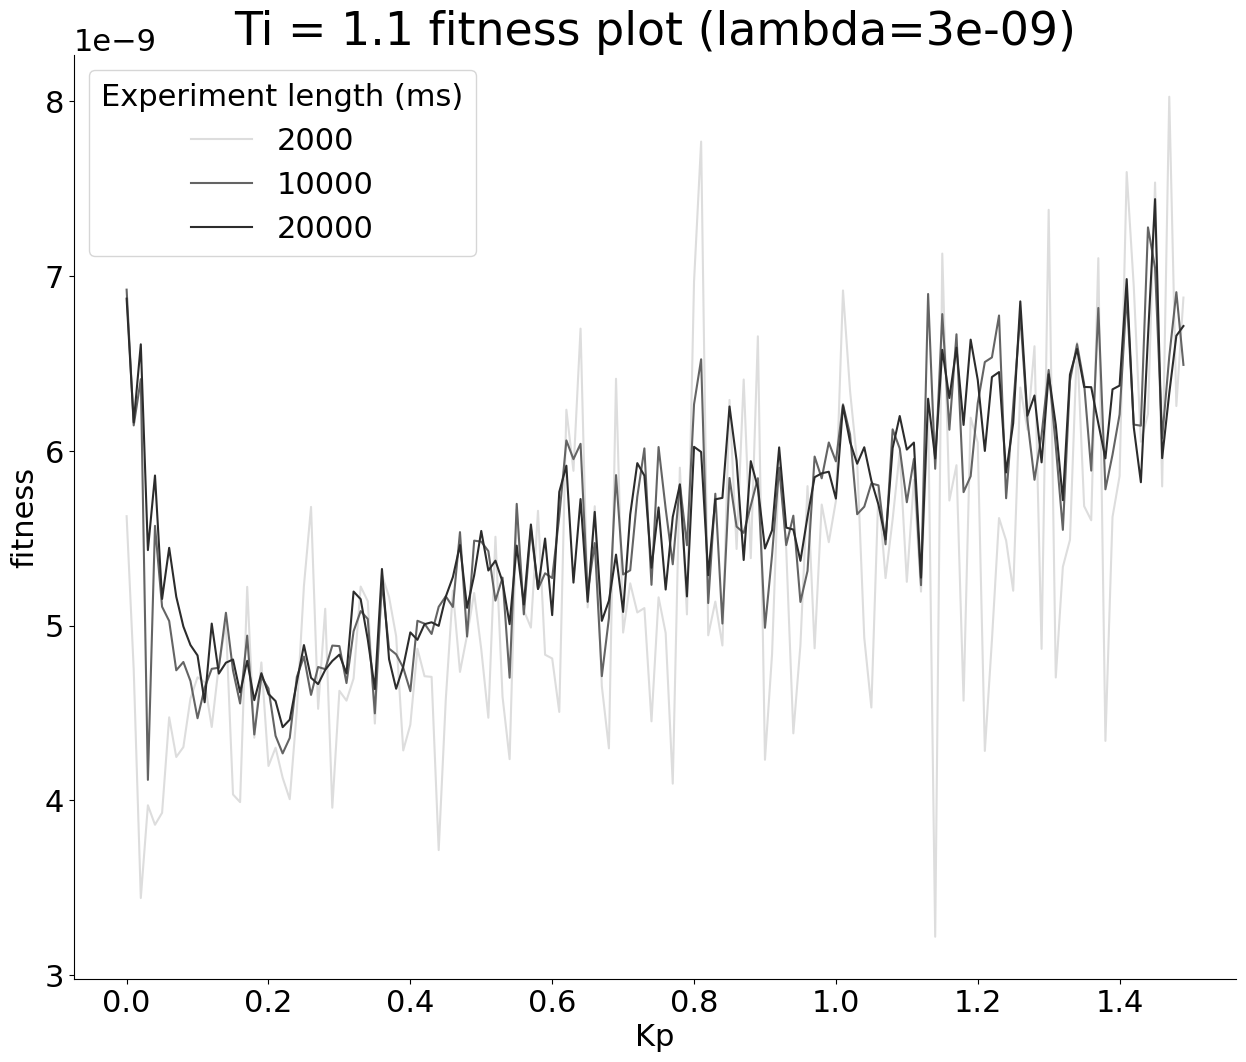

In [8]:
ti = 1.1
plotted = 'fitness'

tail_lengths_display = [2000, 10000, 20000]
skip = int(len(line_colors) / len(tail_lengths_display))
display_colours = line_colors[-len(tail_lengths_display) * skip::skip]

fontsize = 22
fig = plt.figure(figsize=(15, 12))
plt.xlabel('Kp', fontsize=fontsize)
plt.ylabel(f'{plotted}', fontsize=fontsize)
if plotted == 'fitness':
    plt.title(f'Ti = {ti} {plotted} plot (lambda={lam})', fontsize=fontsize * 1.5)
else:
    plt.title(f'Ti = {ti} {plotted} plot', fontsize=fontsize * 1.5)

for i, tl in enumerate(tail_lengths_display):
    dtypes = [('ti', float), ('kp', float), ('mse', float), ('teed', float), ('j', float)]
    a = np.array(results[tl], dtype=dtypes)
    a.sort(order=['ti', 'kp'])

    xx = [e[1] for e in a if e[0] == ti]
    mse = np.array([e[2] for e in a if e[0] == ti])
    teed = np.array([e[3] for e in a if e[0] == ti])
    j = np.array([e[4] for e in a if e[0] == ti])
    
    if plotted == 'MSE':
        plt.plot(xx, mse, color=display_colours[i])
    elif plotted == 'TEED':
        plt.plot(xx, teed, color=display_colours[i])
    elif plotted == 'fitness':
        plt.plot(xx, j, color=display_colours[i])

ax = plt.gca()
ax.legend(tail_lengths_display, fontsize=fontsize, title='Experiment length (ms)', title_fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.yaxis.get_offset_text().set_fontsize(fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)